In [5]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic demand data for three items
date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='M')
item_ids = ['item1', 'item2', 'item3']
demand_data = pd.DataFrame(index=date_range)

for item_id in item_ids:
    demand_data[item_id] = np.random.randint(50, 200, size=len(date_range))

# Add some seasonal patterns to the demand data
demand_data['item1'] += np.sin(np.arange(len(date_range)) * (2 * np.pi) / 12) * 20
demand_data['item2'] += np.cos(np.arange(len(date_range)) * (2 * np.pi) / 12) * 30
demand_data['item3'] += np.sin(np.arange(len(date_range)) * (2 * np.pi) / 6) * 40

# Add some random noise to the demand data
demand_data += np.random.normal(0, 10, size=demand_data.shape)

# Clip negative values to zero
demand_data[demand_data < 0] = 0

# Round demand values to integers
demand_data = demand_data.round().astype(int)

# Save demand data to CSV files
for item_id in item_ids:
    demand_data[item_id].to_csv(f"data/{item_id}_demand.csv", header=['Demand'], index_label='Date')

# Display the first few rows of the demand data
print("Sample Demand Data:")
print(demand_data.head())


Sample Demand Data:
            item1  item2  item3
2022-01-31    142    118     38
2022-02-28    138    140    110
2022-03-31     86     92    167
2022-04-30    182     91     98
2022-05-31    153    131    128


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from multiprocessing import Pool

# Function to fit SARIMA model and make forecast
def sarima_forecast(data):
    # Extract item ID and demand data
    item_id, demand_data = data
    
    # Split data into training and testing sets
    train_data = demand_data[:-12]  # Use data up to the last 12 months for training
    test_data = demand_data[-12:]   # Forecast for the next 12 months
    
    # Fit SARIMA model
    model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = model.fit()
    
    # Make forecast
    forecast = sarima_result.forecast(steps=12)
    
    return item_id, forecast

# Function to fit exponential smoothing model and make forecast
def exponential_smoothing_forecast(data):
    # Extract item ID and demand data
    item_id, demand_data = data
    
    # Split data into training and testing sets
    train_data = demand_data[:-12]  # Use data up to the last 12 months for training
    test_data = demand_data[-12:]   # Forecast for the next 12 months
    
    # Fit exponential smoothing model
    model = ExponentialSmoothing(train_data)
    es_result = model.fit()
    
    # Make forecast
    forecast = es_result.forecast(steps=12)
    
    return item_id, forecast

# Sample function to read demand data from CSV files
def read_demand_data(item_id):
    file_path = f"data/{item_id}_demand.csv"
    demand_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)['Demand']
    return item_id, demand_data

if __name__ == '__main__':
    # Sample item IDs
    item_ids = ['item1', 'item2', 'item3']
    
    # Read demand data for each item
    pool = Pool()  # Create a pool of worker processes
    demand_data_list = pool.map(read_demand_data, item_ids)
    
    # Close the pool
    pool.close()
    pool.join()
    
    # Forecast demand using SARIMA
    sarima_forecasts = []
    for item_id, demand_data in demand_data_list:
        sarima_forecasts.append(sarima_forecast((item_id, demand_data)))
    
    # Forecast demand using exponential smoothing
    es_forecasts = []
    for item_id, demand_data in demand_data_list:
        es_forecasts.append(exponential_smoothing_forecast((item_id, demand_data)))
    
    # Print SARIMA forecasts
    print("SARIMA Forecasts:")
    for item_id, forecast in sarima_forecasts:
        print(f"Item ID: {item_id}, Forecast: {forecast}")
    
    # Print exponential smoothing forecasts
    print("\nExponential Smoothing Forecasts:")
    for item_id, forecast in es_forecasts:
        print(f"Item ID: {item_id}, Forecast: {forecast}")


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from multiprocessing import Pool

# Function to fit SARIMA model and make forecast
def sarima_forecast(data):
    item_id, demand_data = data
    train_data = demand_data[:-12]  # Use data up to the last 12 months for training
    if len(train_data) < 24:
        return item_id, [np.nan] * 12  # Return NaN forecasts if insufficient data
    model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima_result = model.fit()
    forecast = sarima_result.forecast(steps=12)
    return item_id, forecast

# Function to fit exponential smoothing model and make forecast
def exponential_smoothing_forecast(data):
    item_id, demand_data = data
    train_data = demand_data[:-12]  # Use data up to the last 12 months for training
    model = ExponentialSmoothing(train_data)
    es_result = model.fit()
    forecast = es_result.forecast(steps=12)
    return item_id, forecast

# Sample function to read demand data from CSV files
def read_demand_data(item_id):
    file_path = f"data/{item_id}_demand.csv"
    demand_data = pd.read_csv(file_path, index_col='Date', parse_dates=True, freq='M')['Demand']
    return item_id, demand_data

if __name__ == '__main__':
    # Sample item IDs
    item_ids = ['item1', 'item2', 'item3']
    
    # Read demand data for each item
    pool = Pool()  # Create a pool of worker processes
    demand_data_list = pool.map(read_demand_data, item_ids)
    
    # Close the pool
    pool.close()
    pool.join()
    
    # Forecast demand using SARIMA
    sarima_forecasts = [sarima_forecast(data) for data in demand_data_list]
    
    # Forecast demand using exponential smoothing
    es_forecasts = [exponential_smoothing_forecast(data) for data in demand_data_list]
    
    # Print SARIMA forecasts
    print("SARIMA Forecasts:")
    for item_id, forecast in sarima_forecasts:
        print(f"Item ID: {item_id}, Forecast: {forecast}")
    
    # Print exponential smoothing forecasts
    print("\nExponential Smoothing Forecasts:")
    for item_id, forecast in es_forecasts:
        print(f"Item ID: {item_id}, Forecast: {forecast}")


     sales_date  Qty
0    2021-01-01  219
1    2021-01-02  989
2    2021-01-03  130
3    2021-01-04  467
4    2021-01-05  981
...         ...  ...
1090 2023-12-27  741
1091 2023-12-28  241
1092 2023-12-29   13
1093 2023-12-30  679
1094 2023-12-31  733

[1095 rows x 2 columns]


<AxesSubplot:xlabel='sales_date'>

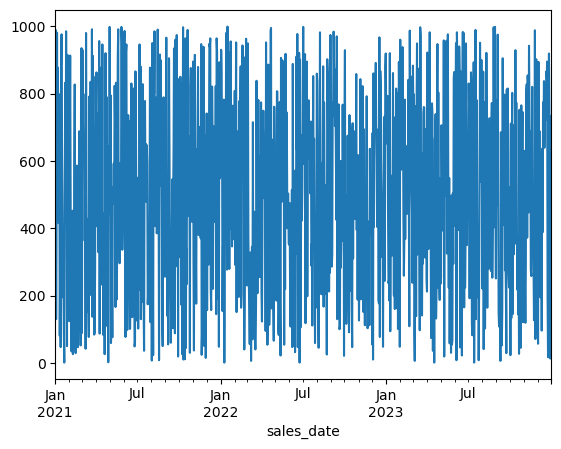

In [44]:
import pandas as pd

import seaborn as sns

# Define start and end dates for all 3 years
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2023-12-31')

# Create a date range for all days within the 3 years
date_range = pd.date_range(start_date, end_date)

# Define a function to generate random sales data (you can adjust the logic)
def generate_sales(date):
 
  return np.random.randint(1, 1000)

# Create an empty DataFrame with 'sales_date' and 'Qty' columns
df = pd.DataFrame({'sales_date': date_range})

# Add a 'Qty' column with random sales data for each date
df['Qty'] = df['sales_date'].apply(generate_sales)




# Print the resulting DataFrame with dummy data for all 3 years
print(df)

# df['Qty'].plot()

df.index = df['sales_date']

df['Qty'].plot()



In [51]:
import datetime as dt
df['Year'] = df['sales_date'].dt.year
df.head()


,sales_date,Qty,Year
sales_date,,,
2021-01-01,2021-01-01,219,2021
2021-01-02,2021-01-02,989,2021
2021-01-03,2021-01-03,130,2021
2021-01-04,2021-01-04,467,2021
2021-01-05,2021-01-05,981,2021


<AxesSubplot:xlabel='Year', ylabel='Qty'>

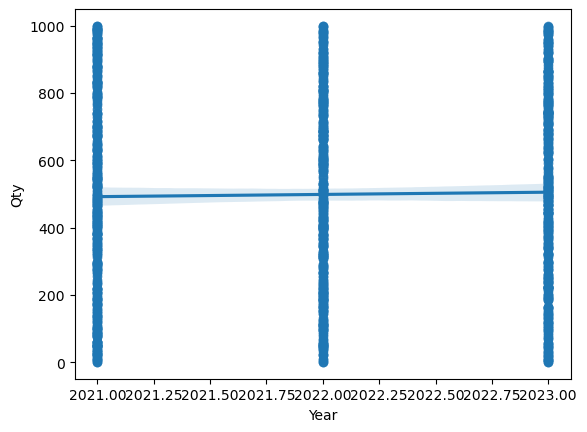

In [54]:
sns.regplot(x = df['Year'], y = df['Qty'])


In [55]:
from statsmodels.tsa.arima.model import ARIMA
# Train the ARIMA model
def train_arima_model(data):
    # Define parameters for ARIMA model (p, d, q)
    p, d, q = 1, 1, 1
    # Fit ARIMA model to data
    model = ARIMA(data, order=(p, d, q))
    fitted_model = model.fit()
    return fitted_model

In [56]:
##integration with portal
def forecast_quantity(start_date, end_date, forecast_horizon):
    # Filter historical sales data for the selected item and date range
    item_sales_data = df[(df['sales_date'] >= start_date) & 
                            (df['sales_date']  <= end_date)]
    # Train the ARIMA model using filtered sales data
    item_model = train_arima_model(item_sales_data['Qty'])
    # Forecast using the trained model
    forecast = item_model.forecast(steps=forecast_horizon)
    return forecast

In [60]:
# uodate user interface 
# # Example usage in your portal's backend API
# @app.route('/forecast', methods=['POST'])
def forecast_endpoint():
#     item_id = request.json['item_id']
#     start_date = request.json['start_date']
#     end_date = request.json['end_date']
#     forecast_horizon = request.json['forecast_horizon']
    start_date = '2023-01-01'
    end_date = '2023-01-31'
    forecast_horizon = 30
    
    # Call forecast_quantity function with user inputs
    forecast = forecast_quantity(start_date, end_date, forecast_horizon)
    
    # Return forecasted quantity to frontend
    #return jsonify({'forecast': forecast})
    
    print(forecast)


In [61]:
forecast_endpoint()

2023-02-01    587.270369
2023-02-02    457.808723
2023-02-03    488.888343
2023-02-04    481.427116
2023-02-05    483.218319
2023-02-06    482.788308
2023-02-07    482.891540
2023-02-08    482.866757
2023-02-09    482.872707
2023-02-10    482.871278
2023-02-11    482.871621
2023-02-12    482.871539
2023-02-13    482.871559
2023-02-14    482.871554
2023-02-15    482.871555
2023-02-16    482.871555
2023-02-17    482.871555
2023-02-18    482.871555
2023-02-19    482.871555
2023-02-20    482.871555
2023-02-21    482.871555
2023-02-22    482.871555
2023-02-23    482.871555
2023-02-24    482.871555
2023-02-25    482.871555
2023-02-26    482.871555
2023-02-27    482.871555
2023-02-28    482.871555
2023-03-01    482.871555
2023-03-02    482.871555
Freq: D, Name: predicted_mean, dtype: float64


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [6]:
# Plot the original data
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Qty'])  # Plot only the 'Qty' column
plt.title('Monthly Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Ensure 'Qty' column is of numerical type
data['Qty'] = pd.to_numeric(data['Qty'])

# Convert DataFrame to numpy array
data_array = np.asarray(data)

# Fit ARIMA model
model = ARIMA(data['Qty'], order=(5,1,0)) # Example order, you may need to tune this
model_fit = model.fit()

# Forecast for the next 30 days
forecast = model_fit.forecast(steps=30)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Qty'], label='Original Data')
plt.plot(pd.date_range(start=data.index[-1], periods=30, freq='D'), forecast, label='Forecast')
plt.title('Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()



KeyError: "None of ['date'] are in the columns"

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        12 non-null     object
 1   Qty         12 non-null     int64 
 2   item_name   12 non-null     object
dtypes: int64(1), object(2)
memory usage: 416.0+ bytes
